In [1]:
import numpy as np
import cupy as cp
from scipy.linalg import inv, expm
import networkx as nx
import time
import cupyx.scipy.linalg as cpx_scipy
from cupyx.profiler import benchmark
import os
import pickle
from tqdm import tqdm
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

from qwak_cupy.qwak import QWAK as CQWAK
from qwak.qwak import QWAK as QWAK



In [2]:
def runTimedQWAK(n,pVal,t,seed, hpc = False):
    initNodes = [n//2]
    graph = nx.erdos_renyi_graph(n,pVal,seed=seed)
    start_time = time.time()
    qw = QWAK(graph) if not hpc else CQWAK(graph)
    qw.runWalk(t, initNodes)
    end_time = time.time()
    qwak_time = end_time - start_time
    final_state = qw.getProbVec()
    return final_state, qwak_time

def runTimedQWAK_anim(qwak,t, hpc = False):
    start_time = time.time()
    qwak.runWalk(t)
    end_time = time.time()
    qwak_time = end_time - start_time
    final_state = qwak.getProbVec()
    return final_state, qwak_time

def runMultipleAnimQWAK(n, pVal, tList, samples, seed, base_dir, hpc=False):
    qwList = []
    tList_storage = []
    qw = 0

    initNodes = [n//2]
    graph = nx.erdos_renyi_graph(n, pVal, seed=seed)
    qwak = QWAK(graph, initStateList=initNodes)

    for t in tqdm(tList, desc=f"NPQWAK {len(tList)}:{tList[0]}->{tList[-1]}" if not hpc else f"CuPyQWAK {len(tList)}:{tList[0]}->{tList[-1]}", leave=False):
        t_dir = os.path.join(base_dir, f"t{t}")
        os.makedirs(t_dir, exist_ok=True)
        avg_file = os.path.join(t_dir, f"AVG-t_P{pVal}_N{n}_sample{samples}.pkl")
        qwak_time_average = 0
        for sample in tqdm(range(1, samples + 1), desc=f"Samples for t = {t}", leave=False):
            t_file = os.path.join(t_dir, f"t_P{pVal}_N{n}_sample{sample}.pkl")
            qw_file = os.path.join(t_dir, f"qw_P{pVal}_N{n}_sample{sample}.pkl")

            if os.path.exists(t_file) and os.path.exists(qw_file):
                # Skip existing samples but continue processing others
                # print(f"Files for N={n}, Sample={sample} already exist. Skipping.")
                continue  # Changed from break to continue
            
            qw, qwak_time = runTimedQWAK_anim(qwak, t, hpc=hpc)
            qwak_time_average += qwak_time

            # Save t and qw for the current sample
            with open(t_file, 'wb') as f:
                pickle.dump(qwak_time, f)
            with open(qw_file, 'wb') as f:
                pickle.dump(qw, f)

        qwak_time_average = qwak_time_average / samples

        with open(avg_file, 'wb') as f:
            pickle.dump(qwak_time_average, f)

    return

def load_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir):  # Added samples parameter
    qwList = []
    tList_storage = []
    avgList = []

    for t in tqdm(tList, desc="Loading NPQWAK data"):
        t_dir = os.path.join(base_dir, f"t{t}")

        qwList_n = []
        tList_n = []
        avg_file = os.path.join(t_dir, f"AVG-t_P{pVal}_N{n}_sample{samples}.pkl")  # Now uses samples parameter

        if os.path.exists(avg_file):
            with open(avg_file, 'rb') as f:
                avgList.append(pickle.load(f))
        else:
            avgList.append(None)

        sample = 1
        while True:
            t_file = os.path.join(t_dir, f"t_P{pVal}_N{n}_sample{sample}.pkl")
            qw_file = os.path.join(t_dir, f"qw_P{pVal}_N{n}_sample{sample}.pkl")
            if os.path.exists(t_file) and os.path.exists(qw_file):
                with open(t_file, 'rb') as f:
                    tList_n.append(pickle.load(f))
                with open(qw_file, 'rb') as f:
                    qwList_n.append(pickle.load(f))
                sample += 1
            else:
                break

        if qwList_n and tList_n:
            tList_storage.append(tList_n)
            qwList.append(qwList_n)

    return tList_storage, qwList, avgList

In [3]:
# Parameters
n = 600
tMin = 1
tMax = 100
tList = list(range(tMin, tMax, 1))
pVal = 0.8
samples = 10
seed = 10

base_dir_cupy_970 = f'Datasets/Benchmark-AnimQWAK_ER_N{n}-CuPy_970'
base_dir = f'Datasets/Benchmark-AnimQWAK_ER_N{n}-NumPy'

start_datetime = datetime.now()

# runMultipleAnimQWAK(n, pVal, tList, samples, seed, base_dir, hpc=False)
tBenchList, qwList, avg_list = load_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir)  # Passed samples

# runMultipleAnimQWAK(n, pVal, tList, samples, seed, base_dir_cupy_970, hpc=True)
tBenchList_cupy_970, qwList_cupy_970, avg_list_cupy_970 = load_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir_cupy_970)  # Passed samples
print('CuPy QWAK results computed and saved.')
elapsed_time = datetime.now() - start_datetime
print(f"Elapsed time: {elapsed_time}")

Loading NPQWAK data: 100%|██████████| 99/99 [00:00<00:00, 275.84it/s]

CuPy QWAK results computed and saved.
Elapsed time: 0:00:00.732903


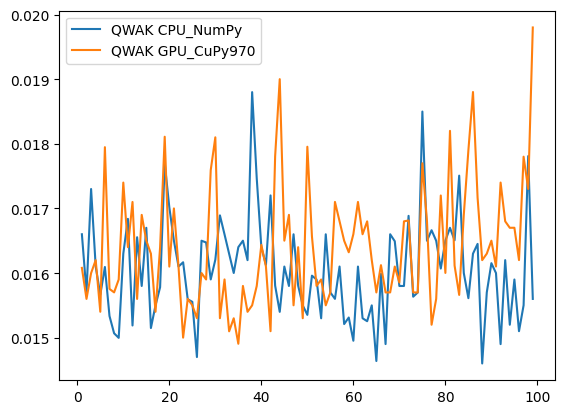

In [4]:
plt.plot(tList, avg_list, label='QWAK CPU_NumPy')
plt.plot(tList, avg_list_cupy_970, label='QWAK GPU_CuPy970')  # Use tList for x-axis
plt.legend()

In [ ]:
def runTimedQWAK(n,pVal,t,seed, hpc = False):
    initNodes = [n//2]
    graph = nx.erdos_renyi_graph(n,pVal,seed=seed)
    start_time = time.time()
    qw = QWAK(graph) if not hpc else CQWAK(graph)
    qw.runWalk(t, initNodes)
    end_time = time.time()
    qwak_time = end_time - start_time
    final_state = qw.getProbVec()
    return final_state, qwak_time

def runTimedQWAK_anim(qwak,t, hpc = False):
    start_time = time.time()
    qwak.runWalk(t)
    end_time = time.time()
    qwak_time = end_time - start_time
    final_state = qwak.getProbVec()
    return final_state, qwak_time

def load_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir):  # Added samples parameter
    qwList = []
    tList_storage = []
    avgList = []

    for t in tqdm(tList, desc="Loading NPQWAK data"):
        t_dir = os.path.join(base_dir, f"t{t}")

        qwList_n = []
        tList_n = []
        avg_file = os.path.join(t_dir, f"AVG-t_P{pVal}_N{n}_sample{samples}.pkl")  # Now uses samples parameter

        if os.path.exists(avg_file):
            with open(avg_file, 'rb') as f:
                avgList.append(pickle.load(f))
        else:
            avgList.append(None)

        sample = 1
        while True:
            t_file = os.path.join(t_dir, f"t_P{pVal}_N{n}_sample{sample}.pkl")
            qw_file = os.path.join(t_dir, f"qw_P{pVal}_N{n}_sample{sample}.pkl")
            if os.path.exists(t_file) and os.path.exists(qw_file):
                with open(t_file, 'rb') as f:
                    tList_n.append(pickle.load(f))
                with open(qw_file, 'rb') as f:
                    qwList_n.append(pickle.load(f))
                sample += 1
            else:
                break

        if qwList_n and tList_n:
            tList_storage.append(tList_n)
            qwList.append(qwList_n)

    return tList_storage, qwList, avgList

In [39]:
def runTimedQWAK(n,pVal,tList,seed, hpc = False):
    initNodes = [n//2]
    graph = nx.erdos_renyi_graph(n,pVal,seed=seed)
    
    start_time = time.time()
    qw = QWAK(graph) if not hpc else CQWAK(graph)
    for t in tqdm(tList, desc=f"NPQWAK {len(tList)}:{tList[0]}->{tList[-1]}" if not hpc else f"CuPyQWAK {len(tList)}:{tList[0]}->{tList[-1]}", leave=False):
        qw.runWalk(t, initNodes)
    end_time = time.time()
    qwak_time = end_time - start_time
    # final_state = qw.getProbVec()
    
    return qwak_time#final_state, qwak_time

def runInitTimedQWAK(n,pVal,tList, seed,base_dir, hpc = False):
    initNodes = [n//2]
    graph = nx.erdos_renyi_graph(n,pVal,seed=seed)
    qwak_init_average = 0
    
    init_time_dir = os.path.join(base_dir, f"init_time_n{n}")
    os.makedirs(init_time_dir, exist_ok=True)
    init_avg_file = os.path.join(init_time_dir, f"AVG-t_P{pVal}_N{n}_samples{samples}.pkl") 
    for sample in tqdm(range(1, samples + 1), desc=f"QWAK Init for N={n}", leave=False):
        qwak_init_t_file = os.path.join(init_time_dir, f"t_P{pVal}_N{n}_sample{sample}.pkl")
        qwak_init_qw_file = os.path.join(init_time_dir, f"qw_P{pVal}_N{n}_sample{sample}.pkl")
        
        qwak_init_start_time = time.time()
        qw = QWAK(graph) if not hpc else CQWAK(graph)
        qwak_init_end_time = time.time()
        qwak_init_time = qwak_init_end_time - qwak_init_start_time
        qwak_init_average += qwak_init_time
        
        with open(qwak_init_t_file, 'wb') as f:
                pickle.dump(qwak_init_time, f)
        with open(qwak_init_qw_file, 'wb') as f:
                pickle.dump(qw.getProbVec(), f)    
            
    qwak_init_average = qwak_init_average / samples
    with open(init_avg_file, 'wb') as f:
                pickle.dump(qwak_init_average, f)
        
    return qwak_init_average, qw
    
def runMultipleAnimQWAK(n, pVal, tList, samples, seed, base_dir, hpc=False):

    
    qwak_init_average, qw_init = runInitTimedQWAK(n,pVal,tList, seed,base_dir, hpc = False)

    for t in tqdm(tList, desc=f"NPQWAK {len(tList)}:{tList[0]}->{tList[-1]}" if not hpc else f"CuPyQWAK {len(tList)}:{tList[0]}->{tList[-1]}", leave=False):
        t_dir = os.path.join(base_dir, f"t{t}")
        os.makedirs(t_dir, exist_ok=True)
        avg_file = os.path.join(t_dir, f"AVG-t_P{pVal}_N{n}_sample{samples}.pkl")
        qwak_time_average = 0
        for sample in tqdm(range(1, samples + 1), desc=f"Samples for t = {t}", leave=False):
            t_file = os.path.join(t_dir, f"t_P{pVal}_N{n}_sample{sample}.pkl")
            qw_file = os.path.join(t_dir, f"qw_P{pVal}_N{n}_sample{sample}.pkl")

            if os.path.exists(t_file) and os.path.exists(qw_file):
                # Skip existing samples but continue processing others
                # print(f"Files for N={n}, Sample={sample} already exist. Skipping.")
                continue  # Changed from break to continue
            start_time = time.time()
            qw_init.runWalk(t)
            end_time = time.time()
            qwak_time = end_time - start_time
            
            # qw, qwak_time = runTimedQWAK_anim(qwak, t, hpc=hpc)
            qwak_time_average += qwak_time

            # Save t and qw for the current sample
            with open(t_file, 'wb') as f:
                pickle.dump(qwak_time, f)
            with open(qw_file, 'wb') as f:
                pickle.dump(qw_init.getProbVec(), f)

        qwak_time_average = qwak_time_average / samples

        with open(avg_file, 'wb') as f:
            pickle.dump(qwak_time_average, f)# Parameters

    return

def load_init_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir, hpc = False):  # Added samples parameter
    qwList = []
    tList_storage = []
    avgList = []
    
    init_dir = os.path.join(base_dir, f"init_time_n{n}")
    
    init_tList_storage = []
    init_qwList = []
    init_avg_file = os.path.join(init_dir, f"AVG-t_P{pVal}_N{n}_samples{samples}.pkl")
    init_avg_list = []
    
    if os.path.exists(init_avg_file):
            with open(init_avg_file, 'rb') as f:
                init_avg_list.append(pickle.load(f))
    else:
        init_avg_list.append(None)
    
    for sample in tqdm(range(1, samples + 1), desc=f"QWAK Init for N={n}", leave=False):
        init_t_file = os.path.join(init_dir, f"t_P{pVal}_N{n}_sample{sample}.pkl")
        init_qw_file = os.path.join(init_dir, f"qw_P{pVal}_N{n}_sample{sample}.pkl")

        init_tList_n = []
        init_qwList_n = []
        if os.path.exists(init_t_file) and os.path.exists(init_qw_file):
            with open(init_t_file, 'rb') as f:
                init_tList_n.append(pickle.load(f))
            with open(init_qw_file, 'rb') as f:
                init_qwList_n.append(pickle.load(f))
        else:
            break

        if init_tList_n and init_qwList_n:
            init_tList_storage.append(init_tList_n)
            init_qwList.append(init_qwList_n)

    return init_tList_storage,init_qwList,init_avg_list

def load_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir, hpc = False):  # Added samples parameter
    init_tList_storage,init_qwList,init_avg_list = load_init_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir)  # Passed samples
    
    qwList = []
    tList_storage = []
    avgList = []

    for t in tqdm(tList, desc="Loading NPQWAK data"):
        t_dir = os.path.join(base_dir, f"t{t}")
        print(t_dir)

        qwList_n = []
        tList_n = []
        avg_file = os.path.join(t_dir, f"AVG-t_P{pVal}_N{n}_sample{samples}.pkl")  # Now uses samples parameter

        if os.path.exists(avg_file):
            with open(avg_file, 'rb') as f:
                avg_time = pickle.load(f)
                if t == tList[0]:
                    avg_time += init_avg_list[0]
                avgList.append(avg_time)
                # avgList.append(pickle.load(f))
        else:
            avgList.append(None)

        sample = 1
        while True:
            t_file = os.path.join(t_dir, f"t_P{pVal}_N{n}_sample{sample}.pkl")
            qw_file = os.path.join(t_dir, f"qw_P{pVal}_N{n}_sample{sample}.pkl")
            if os.path.exists(t_file) and os.path.exists(qw_file):
                with open(t_file, 'rb') as f:
                    tList_n.append(pickle.load(f))
                with open(qw_file, 'rb') as f:
                    qwList_n.append(pickle.load(f))
                sample += 1
            else:
                break

        if qwList_n and tList_n:
            tList_storage.append(tList_n)
            qwList.append(qwList_n)

    return tList_storage, qwList, avgList

n = 1000
tMin = 1
tMax = 100
tList = list(range(tMin, tMax, 1))
pVal = 0.8
samples = 10
seed = 10

base_dir_cupy_970 = f'Datasets/Benchmark-AnimQWAK_ER_N{n}-CuPy_970_2'
base_dir = f'Datasets/Benchmark-AnimQWAK_ER_N{n}-NumPy_2'

start_datetime = datetime.now()

runMultipleAnimQWAK(n, pVal, tList, samples, seed, base_dir, hpc=False)
tBenchList, qwList, avg_list = load_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir)  # Passed samples
print(avg_list)
runMultipleAnimQWAK(n, pVal, tList, samples, seed, base_dir_cupy_970, hpc=True)
tBenchList_cupy_970, qwList_cupy_970, avg_list_cupy_970 = load_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir_cupy_970)  # Passed samples
print('CuPy QWAK results computed and saved.')
elapsed_time = datetime.now() - start_datetime
print(f"Elapsed time: {elapsed_time}")



Samples for t = 1:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 2:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 3:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 4:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 5:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 6:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 7:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 8:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 9:   0%|          | 0/10 [00:00<?, ?it/s]
              

Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t1
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t2
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t3
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t4
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t5
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t6
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t7
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t8
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t9
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t10
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t11
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t12
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t13
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t14
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t15
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t16
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t17
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t18
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t19
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t20
Datasets/Benchmark-AnimQWAK_E

Loading NPQWAK data: 100%|██████████| 99/99 [00:00<00:00, 261.89it/s]


Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t55
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t56
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t57
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t58
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t59
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t60
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t61
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t62
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t63
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t64
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t65
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t66
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t67
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t68
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t69
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t70
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t71
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t72
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t73
Datasets/Benchmark-AnimQWAK_ER_N1000-NumPy_2\t74
Datasets/Benchmark-A

Samples for t = 1:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 2:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 3:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 4:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 5:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 6:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 7:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 8:   0%|          | 0/10 [00:00<?, ?it/s]
                                                         
Samples for t = 9:   0%|          | 0/10 [00:00<?, ?it/s]
              

Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t1
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t2
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t3
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t4
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t5
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t6
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t7
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t8
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t9
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t10
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t11
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t12
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t13
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t14
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t15
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t16
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t17
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t18
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t19
Datasets/Benchmark-An

Loading NPQWAK data: 100%|██████████| 99/99 [00:00<00:00, 253.43it/s]

Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t52
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t53
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t54
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t55
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t56
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t57
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t58
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t59
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t60
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t61
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t62
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t63
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t64
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t65
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t66
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t67
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t68
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t69
Datasets/Benchmark-AnimQWAK_ER_N1000-CuPy_970_2\t70
Datasets/Ben

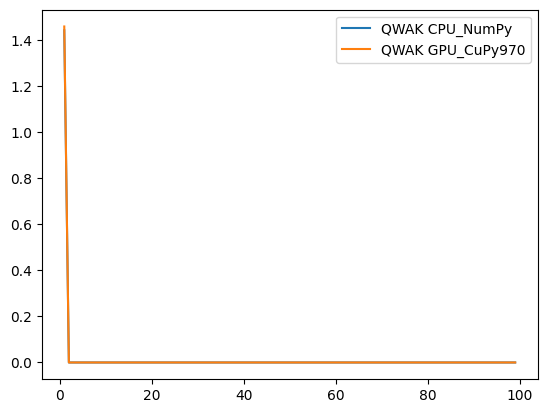

In [40]:
plt.plot(tList, avg_list, label='QWAK CPU_NumPy')
plt.plot(tList, avg_list_cupy_970, label='QWAK GPU_CuPy970')  # Use tList for x-axis
plt.legend()

In [41]:
def runTimedQWAK(n,pVal,tList,seed, hpc = False):
    initNodes = [n//2]
    graph = nx.erdos_renyi_graph(n,pVal,seed=seed)
    
    start_time = time.time()
    qw = QWAK(graph) if not hpc else CQWAK(graph)
    for t in tqdm(tList, desc=f"NPQWAK {len(tList)}:{tList[0]}->{tList[-1]}" if not hpc else f"CuPyQWAK {len(tList)}:{tList[0]}->{tList[-1]}", leave=False):
        qw.runWalk(t, initNodes)
    end_time = time.time()
    qwak_time = end_time - start_time
    # final_state = qw.getProbVec()
    
    return qwak_time#final_state, qwak_time

def runInitTimedQWAK(n,pVal,tList, seed,base_dir, hpc = False):
    initNodes = [n//2]
    graph = nx.erdos_renyi_graph(n,pVal,seed=seed)
    qwak_init_average = 0
    
    init_time_dir = os.path.join(base_dir, f"init_time_n{n}")
    os.makedirs(init_time_dir, exist_ok=True)
    init_avg_file = os.path.join(init_time_dir, f"AVG-t_P{pVal}_N{n}_samples{samples}.pkl") 
    for sample in tqdm(range(1, samples + 1), desc=f"QWAK Init for N={n}", leave=False):
        qwak_init_t_file = os.path.join(init_time_dir, f"t_P{pVal}_N{n}_sample{sample}.pkl")
        qwak_init_qw_file = os.path.join(init_time_dir, f"qw_P{pVal}_N{n}_sample{sample}.pkl")
        
        qwak_init_start_time = time.time()
        qw = QWAK(graph) if not hpc else CQWAK(graph)
        qwak_init_end_time = time.time()
        qwak_init_time = qwak_init_end_time - qwak_init_start_time
        qwak_init_average += qwak_init_time
        
        with open(qwak_init_t_file, 'wb') as f:
                pickle.dump(qwak_init_time, f)
        with open(qwak_init_qw_file, 'wb') as f:
                pickle.dump(qw.getProbVec(), f)    
            
    qwak_init_average = qwak_init_average / samples
    with open(init_avg_file, 'wb') as f:
                pickle.dump(qwak_init_average, f)
        
    return qwak_init_average, qw
    
def runMultipleAnimQWAK(n, pVal, tList, samples, seed, base_dir, hpc=False):

    
    qwak_init_average, qw_init = runInitTimedQWAK(n,pVal,tList, seed,base_dir, hpc = False)

    for t in tqdm(tList, desc=f"NPQWAK {len(tList)}:{tList[0]}->{tList[-1]}" if not hpc else f"CuPyQWAK {len(tList)}:{tList[0]}->{tList[-1]}", leave=False):
        t_dir = os.path.join(base_dir, f"t{t}")
        os.makedirs(t_dir, exist_ok=True)
        avg_file = os.path.join(t_dir, f"AVG-t_P{pVal}_N{n}_sample{samples}.pkl")
        qwak_time_average = 0
        for sample in tqdm(range(1, samples + 1), desc=f"Samples for t = {t}", leave=False):
            t_file = os.path.join(t_dir, f"t_P{pVal}_N{n}_sample{sample}.pkl")
            qw_file = os.path.join(t_dir, f"qw_P{pVal}_N{n}_sample{sample}.pkl")

            if os.path.exists(t_file) and os.path.exists(qw_file):
                # Skip existing samples but continue processing others
                # print(f"Files for N={n}, Sample={sample} already exist. Skipping.")
                continue  # Changed from break to continue
            start_time = time.time()
            qw_init.runExpmWalk(t)
            end_time = time.time()
            qwak_time = end_time - start_time
            
            # qw, qwak_time = runTimedQWAK_anim(qwak, t, hpc=hpc)
            qwak_time_average += qwak_time

            # Save t and qw for the current sample
            with open(t_file, 'wb') as f:
                pickle.dump(qwak_time, f)
            with open(qw_file, 'wb') as f:
                pickle.dump(qw_init.getProbVec(), f)

        qwak_time_average = qwak_time_average / samples

        with open(avg_file, 'wb') as f:
            pickle.dump(qwak_time_average, f)# Parameters

    return

def load_init_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir, hpc = False):  # Added samples parameter
    qwList = []
    tList_storage = []
    avgList = []
    
    init_dir = os.path.join(base_dir, f"init_time_n{n}")
    
    init_tList_storage = []
    init_qwList = []
    init_avg_file = os.path.join(init_dir, f"AVG-t_P{pVal}_N{n}_samples{samples}.pkl")
    init_avg_list = []
    
    if os.path.exists(init_avg_file):
            with open(init_avg_file, 'rb') as f:
                init_avg_list.append(pickle.load(f))
    else:
        init_avg_list.append(None)
    
    for sample in tqdm(range(1, samples + 1), desc=f"QWAK Init for N={n}", leave=False):
        init_t_file = os.path.join(init_dir, f"t_P{pVal}_N{n}_sample{sample}.pkl")
        init_qw_file = os.path.join(init_dir, f"qw_P{pVal}_N{n}_sample{sample}.pkl")

        init_tList_n = []
        init_qwList_n = []
        if os.path.exists(init_t_file) and os.path.exists(init_qw_file):
            with open(init_t_file, 'rb') as f:
                init_tList_n.append(pickle.load(f))
            with open(init_qw_file, 'rb') as f:
                init_qwList_n.append(pickle.load(f))
        else:
            break

        if init_tList_n and init_qwList_n:
            init_tList_storage.append(init_tList_n)
            init_qwList.append(init_qwList_n)

    return init_tList_storage,init_qwList,init_avg_list

def load_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir, hpc = False):  # Added samples parameter
    init_tList_storage,init_qwList,init_avg_list = load_init_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir)  # Passed samples
    
    qwList = []
    tList_storage = []
    avgList = []

    for t in tqdm(tList, desc="Loading NPQWAK data"):
        t_dir = os.path.join(base_dir, f"t{t}")
        print(t_dir)

        qwList_n = []
        tList_n = []
        avg_file = os.path.join(t_dir, f"AVG-t_P{pVal}_N{n}_sample{samples}.pkl")  # Now uses samples parameter

        if os.path.exists(avg_file):
            with open(avg_file, 'rb') as f:
                avg_time = pickle.load(f)
                if t == tList[0]:
                    avg_time += init_avg_list[0]
                avgList.append(avg_time)
                # avgList.append(pickle.load(f))
        else:
            avgList.append(None)

        sample = 1
        while True:
            t_file = os.path.join(t_dir, f"t_P{pVal}_N{n}_sample{sample}.pkl")
            qw_file = os.path.join(t_dir, f"qw_P{pVal}_N{n}_sample{sample}.pkl")
            if os.path.exists(t_file) and os.path.exists(qw_file):
                with open(t_file, 'rb') as f:
                    tList_n.append(pickle.load(f))
                with open(qw_file, 'rb') as f:
                    qwList_n.append(pickle.load(f))
                sample += 1
            else:
                break

        if qwList_n and tList_n:
            tList_storage.append(tList_n)
            qwList.append(qwList_n)

    return tList_storage, qwList, avgList

n = 1000
tMin = 1
tMax = 100
tList = list(range(tMin, tMax, 1))
pVal = 0.8
samples = 10
seed = 1

base_dir_cupy_970 = f'Datasets/Benchmark-AnimQWAK_ER_N{n}-CuPy_970_2'
base_dir = f'Datasets/Benchmark-AnimQWAK_ER_N{n}-NumPy_2'

start_datetime = datetime.now()

runMultipleAnimQWAK(n, pVal, tList, samples, seed, base_dir, hpc=False)
tBenchList, qwList, avg_list = load_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir)  # Passed samples
print(avg_list)
runMultipleAnimQWAK(n, pVal, tList, samples, seed, base_dir_cupy_970, hpc=True)
tBenchList_cupy_970, qwList_cupy_970, avg_list_cupy_970 = load_runMultipleAnimQWAK(n, pVal, tList, samples, base_dir_cupy_970)  # Passed samples
print('CuPy QWAK results computed and saved.')
elapsed_time = datetime.now() - start_datetime
print(f"Elapsed time: {elapsed_time}")



KeyboardInterrupt: 